In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv2D, Conv3D
from tensorflow.keras.layers import MaxPooling2D, MaxPooling3D
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras import regularizers
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.losses import binary_crossentropy
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve

from keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image 
import seaborn as sns
import os
import re
import glob
import cv2
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.model_selection import StratifiedKFold
from sklearn import preprocessing
import tqdm
from numpy import loadtxt
from os import *
from sklearn.utils import class_weight

Using TensorFlow backend.


In [2]:
def atoi(text):
    return int(text) if text.isdigit() else text
def natural_keys(text):
    return [atoi(c) for c in re.split('(\d+)', text)]

In [3]:
def draw_confusion_matrix(true,preds):
    conf_matx = confusion_matrix(true, preds)
    sns.heatmap(conf_matx, annot=True,annot_kws={"size": 12},fmt='g', cbar=False, cmap=plt.cm.Blues) #'viridis'
    #plt.savefig('/home/jovyan/img1.png')
    plt.show()
    
    return conf_matx

In [4]:
def plot_history(model_history, model_name):
    fig = plt.figure(figsize=(15,5), facecolor='w')
    ax = fig.add_subplot(121)
    ax.plot(model_history.history['loss'])
    ax.plot(model_history.history['val_loss'])
    ax.set(title=model_name + ': Model loss', ylabel='Loss', xlabel='Epoch')
    ax.legend(['Train', 'Val'], loc='upper left')
    ax = fig.add_subplot(122)
    ax.plot(model_history.history['accuracy'])
    ax.plot(model_history.history['val_accuracy'])
    ax.set(title=model_name + ': Model Accuracy; test='+ str(np.round(model_history.history['val_accuracy'][-1], 3)),
           ylabel='Accuracy', xlabel='Epoch')
    ax.legend(['Train', 'Val'], loc='upper left')
    #plt.show()
    
    return fig

In [5]:
def resize(x):
    rescaled = []

    for i in x:

        scale_percent = 140 # percent of original size
        width = int(i.shape[1] / (scale_percent / 100))
        height = int(i.shape[0] / (scale_percent / 100))
        dim = (width, height)
        resized = cv2.resize(i, dim, interpolation = cv2.INTER_LANCZOS4)
        rescaled.append(resized)

    x_orig = np.reshape( rescaled, (len( rescaled), resized.shape[1], resized.shape[1], 3))

    return x_orig

In [6]:
def loadImages(path_data, path_labels):

    image_list = []
    

    for filename in tqdm.tqdm(sorted(glob.glob(path_data), key=natural_keys)): 
        im=cv2.imread(filename)
        #gray_image = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
        imarray = np.array(im)
        #imarray = imarray.astype('float32')
        image_list.append(imarray)

    x_orig = np.reshape(image_list, (len(image_list), 90, 90, 3))
    
    path = path_labels    
    labels = pd.read_csv(path, usecols=["Type", "Category"],
                       sep="," )
    y_orig = np.array(labels['Category'])

    return x_orig, y_orig

In [7]:
train_data = '/home/jovyan/DATA_MASTER_PROJECT/Check_DIFF_T60_T_97/2_class_CON_METHO/TRAIN_CONT_METHOX/*.tiff'
train_lab='/home/jovyan/DATA_MASTER_PROJECT/Check_DIFF_T60_T_97/2_class_CON_METHO/train_lab.csv'

validation_data = '/home/jovyan/DATA_MASTER_PROJECT/Check_DIFF_T60_T_97/2_class_CON_METHO/VALIDATION_CONT_METHOX/*.tiff'
validation_lab = '/home/jovyan/DATA_MASTER_PROJECT/Check_DIFF_T60_T_97/2_class_CON_METHO/validation_lab.csv'


test_data='/home/jovyan/DATA_MASTER_PROJECT/Check_DIFF_T60_T_97/2_class_CON_METHO/TEST_CONT_METHOX/*.tiff'
test_lab='/home/jovyan/DATA_MASTER_PROJECT/Check_DIFF_T60_T_97/2_class_CON_METHO/test_lab.csv'



In [8]:
x_train, y_train = loadImages(train_data, train_lab)
x_train.shape, y_train.shape

100%|██████████| 16296/16296 [00:15<00:00, 1049.68it/s]


((16296, 90, 90, 3), (16296,))

In [9]:
x_val, y_val = loadImages(validation_data, validation_lab)
x_val.shape, y_val.shape

100%|██████████| 4229/4229 [00:03<00:00, 1110.29it/s]


((4229, 90, 90, 3), (4229,))

In [10]:
x_test, y_test = loadImages(test_data, test_lab)
x_test.shape, y_test.shape

100%|██████████| 5415/5415 [00:04<00:00, 1273.20it/s]


((5415, 90, 90, 3), (5415,))

In [11]:
x_train = resize(x_train)
x_train.shape

(16296, 64, 64, 3)

In [12]:
x_val = resize(x_val)
x_val.shape

(4229, 64, 64, 3)

In [13]:
x_test = resize(x_test)
x_test.shape

(5415, 64, 64, 3)

In [14]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=2, patience=5)

In [15]:
pretrained_model = VGG16(weights='imagenet',include_top=False, input_shape=(64, 64, 3))

base_model = Model(inputs=pretrained_model.input, outputs=pretrained_model.get_layer('block3_pool').output)

In [16]:
weights = class_weight.compute_class_weight('balanced', np.unique(y_train),y_train)
print('weights = ' + str(weights))

weights = [0.81034311 1.30556001]


In [17]:
x_train = preprocess_input(x_train)

x_val = preprocess_input(x_val)

x_test = preprocess_input(x_test)


In [18]:
batch_size = 128

In [19]:
datagen = ImageDataGenerator()

datagen.fit(x_train)

train_gen = datagen.flow(x_train, y_train,batch_size=batch_size )

dat_val = ImageDataGenerator()

dat_val.fit(x_val)

val_gen = dat_val.flow(x_val, y_val,batch_size=batch_size)

m4 = Sequential()
m4.add(base_model)


m4.add(BatchNormalization())
m4.add(GlobalAveragePooling2D())
m4.add(BatchNormalization())
m4.add(Activation('relu'))
m4.add(Dense(64, activation='relu'))
#m4.add(Dropout(0.5))

m4.add(Dense(1,activation='sigmoid'))

m4.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Model)                (None, 8, 8, 256)         1735488   
_________________________________________________________________
batch_normalization (BatchNo (None, 8, 8, 256)         1024      
_________________________________________________________________
global_average_pooling2d (Gl (None, 256)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
activation (Activation)      (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                16448     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 6

In [20]:
base_model.trainable = False

opt = keras.optimizers.Adam(lr=1e-5)

m4.compile(loss= keras.losses.binary_crossentropy, optimizer=opt, metrics = ['accuracy'])



epochs = 100

m4_h = m4.fit(train_gen,
                steps_per_epoch=(len(x_train)/batch_size),
                callbacks = [es],
                epochs=epochs,
                validation_data = (val_gen), 
                validation_steps = (len(x_val)/batch_size),
                class_weight = weights,
                 verbose = 1)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 127.3125 steps, validate for 33.0390625 steps
Epoch 1/100
128/127 [==============================] - 7s 58ms/step - loss: 0.7697 - accuracy: 0.5990 - val_loss: 0.7038 - val_accuracy: 0.6049
Epoch 2/100
128/127 [==============================] - 4s 30ms/step - loss: 0.7239 - accuracy: 0.5852 - val_loss: 0.6902 - val_accuracy: 0.5914
Epoch 3/100
128/127 [==============================] - 4s 30ms/step - loss: 0.7080 - accuracy: 0.5835 - val_loss: 0.6842 - val_accuracy: 0.5933
Epoch 4/100
128/127 [==============================] - 4s 31ms/step - loss: 0.6979 - accuracy: 0.5875 - val_loss: 0.6788 - val_accuracy: 0.5980
Epoch 5/100
128/127 [==============================] - 4s 31ms/step - loss: 0.6889 - accuracy: 0.5959 - val_loss: 0.6733 - val_accuracy: 0.6037
Epoch 6/100
128/127 [==============================] - 4s 31ms/step - loss: 0.6806 - accuracy: 0.6041 - val_loss: 0.6684 - val_accuracy: 0.6087
Epoch 7/100
128/127 [=========

In [21]:
base_model.trainable = True

opt = keras.optimizers.Adam(lr=1e-5)

m4.compile(loss= keras.losses.binary_crossentropy, optimizer=opt, metrics = ['accuracy'])

epochs = 100

m4_h = m4.fit(train_gen,
                steps_per_epoch=(len(x_train)/batch_size),
                callbacks = [es],
                epochs=epochs,
                validation_data = val_gen, 
                validation_steps = (len(x_val)/batch_size),
                class_weight = weights,
                verbose = 1)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 127.3125 steps, validate for 33.0390625 steps
Epoch 1/100
128/127 [==============================] - 10s 80ms/step - loss: 0.3904 - accuracy: 0.8420 - val_loss: 0.5687 - val_accuracy: 0.7214
Epoch 2/100
128/127 [==============================] - 9s 68ms/step - loss: 0.3302 - accuracy: 0.8736 - val_loss: 0.5009 - val_accuracy: 0.7721
Epoch 3/100
128/127 [==============================] - 9s 68ms/step - loss: 0.2900 - accuracy: 0.8937 - val_loss: 0.5065 - val_accuracy: 0.7576
Epoch 4/100
128/127 [==============================] - 9s 68ms/step - loss: 0.2597 - accuracy: 0.9097 - val_loss: 0.4777 - val_accuracy: 0.7799
Epoch 5/100
128/127 [==============================] - 9s 68ms/step - loss: 0.2354 - accuracy: 0.9237 - val_loss: 0.5016 - val_accuracy: 0.7508
Epoch 6/100
128/127 [==============================] - 9s 67ms/step - loss: 0.2146 - accuracy: 0.9339 - val_loss: 0.4671 - val_accuracy: 0.7936
Epoch 7/100
128/127 [========

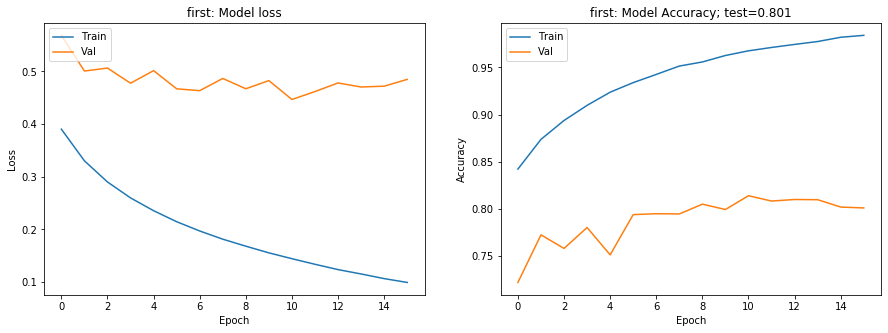

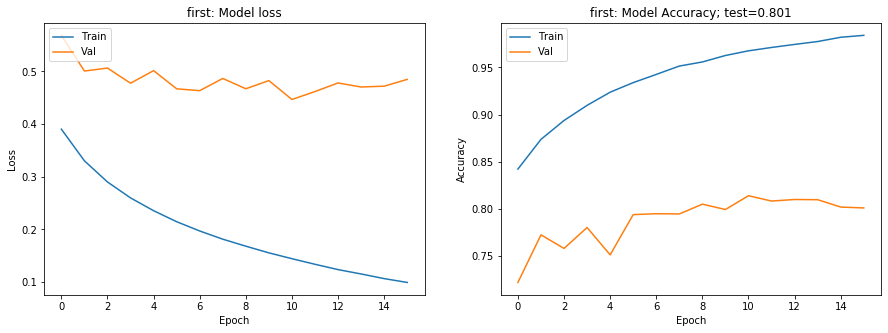

In [22]:
plot_history(m4_h, 'first')

In [43]:
scores = m4.evaluate(x_test, y_test, verbose = 1)
print("\n%s: %.2f%%" % (m4.metrics_names[1], scores[1]*100))


5415/5415 [==============================] - 1s 218us/sample - loss: 0.5069 - accuracy: 0.7734

accuracy: 77.34%


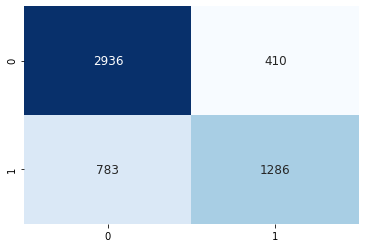

array([[2936,  410],
       [ 783, 1286]])

In [58]:
test_preds = m4.predict(x_test)

t= []
for i in (test_preds):
    if i > 0.6:
        t.append(1)
    else:
        t.append(0)

draw_confusion_matrix(y_test, t)

In [59]:
print(classification_report(y_test, t))

              precision    recall  f1-score   support

           0       0.79      0.88      0.83      3346
           1       0.76      0.62      0.68      2069

    accuracy                           0.78      5415
   macro avg       0.77      0.75      0.76      5415
weighted avg       0.78      0.78      0.77      5415



In [60]:
import sklearn

In [1]:
def plot_roc(name, labels, predictions, **kwargs):
    fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

    plt.plot(fp, tp, label=name, linewidth=2, **kwargs)
    plt.xlabel('False positives [%]')
    plt.ylabel('True positives [%]')
    plt.xlim([-0.5,20])
    plt.ylim([80,100.5])
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

In [2]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

NameError: name 'plt' is not defined

In [3]:
plot_roc('ROC', y_test, t, color=colors[0])
plt.legend(loc='lower right')

NameError: name 'y_test' is not defined

In [47]:
fp, tp, _ = sklearn.metrics.roc_curve(y_test, t)

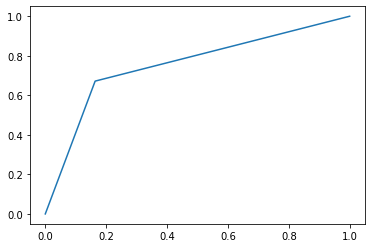

In [62]:
plt.plot(fp,tp)
plt.show()